# MMLU Benchmark

[Massive Multitask Language Understanding (MMLU)](https://github.com/hendrycks/test) is a popular benchmark for evaluating language models' world knowledge and problem solving abilities. The MMLU dataset contains 14,042 multiple choice questions (MCQs) from 57 categories including mathematics, history, biology, and business. Each question has 4 options (A, B, C, D) and one correct answer. In addition, each category includes 5 example questions designed for few shot experiments. When MMLU was first published in 2020, only the largest GPT models could do better than random guessing. By 2024, multiple models from OpenAI, Anthropic, Meta, and Tencent have all published MMLU accuracies over 88%.

# Zero-Shot, Sampled

In this experiment, we'll measure Llama performance against MMLU ourselves. To keep runtime to a reasonable level, we'll randomly select subsets of MMLU questions.

# Parameters

In [1]:
n_iterations = 3
n_questions = 128
checkpoint = "Llama3.2-3B-Instruct"

# Setup

In [2]:
import os
from pathlib import Path
from random import sample
from time import perf_counter_ns as timer

from matplotlib import pyplot as plt
from tqdm.auto import trange, tqdm

import llama_jax as ll
from llama_jax.benchmarks.mmlu import (
    display_questions,
    download_dataset, 
    load_dataset,
    evaluate_generator,
)

In [3]:
# Configure
datasets_path = Path(os.environ["PROJECT_ROOT"]) / ".build" / "datasets"
mmlu_dataset_path = datasets_path / "mmlu"

# Load Dataset

In [4]:
download_dataset(mmlu_dataset_path)

In [5]:
dataset = load_dataset(mmlu_dataset_path)
print(f"Loaded {len(dataset.questions)} questions, {len(dataset.examples)} examples, {len(dataset.categories)} categories")

Loaded 14042 questions, 285 examples, 57 categories


In [6]:
# Display sample
display_questions(dataset.questions)

,qid,category,question,A,B,C,D,answer
0,11134,professional law,A city sent a certified notice by U.S. mail to...,"No, because the sending of certified notice to...","No, because the owner knew that he wasn't payi...","Yes, because in most circumstances an ""unclaim...","No, because the city had a right to expect tha...",C
1,5289,high school psychology,The part of the neuron that directs synthesis ...,cell body,dendrite,axon,axon terminal,A
2,7474,miscellaneous,Which of the following best describes an effec...,Increased varieties of each crop planted,Increased use of fertilizers,Decreased use of mechanization,Decreased use of pesticides,B
3,3338,high school european history,This question refers to the following informat...,the French Republic,the Committee of Public Safety,war against the Coalition,mass conscription,D
4,385,astronomy,The lunar maria are:,ancient heavily cratered highlands,dark lavas inside volcanic calderas,dark lavas filling older impact basins,the bright regions on the Moon,C


# Model

In [7]:
# Initialize mmlu generator from checkpoint
config = ll.checkpoint.load_config(checkpoint)
generator = ll.benchmarks.mmlu.generator(config)

Metal device set to: Apple M1 Max


W0000 00:00:1734727276.677168 11189711 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1734727276.685752 11189711 service.cc:145] XLA service 0x6000011f0b00 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734727276.685761 11189711 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1734727276.686920 11189711 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1734727276.686930 11189711 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


In [8]:
# Pre-compile model
next(generator(sample(dataset.questions, k=1)))

Answer(qid=426, expected='B', actual='B', scores={'A': 0.0002536773681640625, 'B': 0.96875, 'C': 0.005096435546875, 'D': 0.0257568359375}, correct=True)

# Experiment

In [9]:
start_time = timer()

scores = []
for _ in trange(n_iterations, desc="Iterations"):

    # Randomly sample questions
    questions = sample(dataset.questions, k=n_questions)

    # Decorate questions w/ progress bar
    questions = tqdm(questions, desc="Questions", leave=False)
    
    score = evaluate_generator(
        generator,
        questions=questions,
    )
    scores.append(score)

duration = ((timer() - start_time) / 1000000000)

Iterations:   0%|          | 0/3 [00:00<?, ?it/s]

Questions:   0%|          | 0/128 [00:00<?, ?it/s]

Questions:   0%|          | 0/128 [00:00<?, ?it/s]

Questions:   0%|          | 0/128 [00:00<?, ?it/s]

In [10]:
t = duration / (n_iterations * n_questions)
print(f"Average {t:0.2f} s/q")

Average 0.59 s/q


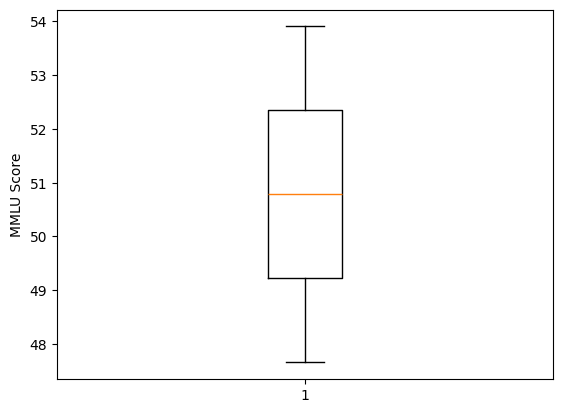

In [11]:
plt.boxplot(scores)
plt.ylabel("MMLU Score")
plt.show()